In [1]:
"""
COURSE: Artificial Intelligence II
Week 6 Assignment: Reinforcement Learning: Environment Navigation Model Using Passive Reinforcement Learning
SEMESTER: Fall 2021
NAME: Joe Cruz
DATE: 09Dec2021

"""

'\nCOURSE: Artificial Intelligence II\nWeek 6 Assignment: Reinforcement Learning: Environment Navigation Model Using Passive Reinforcement Learning\nSEMESTER: Fall 2021\nNAME: Joe Cruz\nDATE: 09Dec2021\n\n'

In [2]:
"""
THIS BLOCK OF CODE IS FROM THE FOLLOWING REFERENCE:
P. Norvig, et al., “mdp.py” [Online]. Available: https://github.com/aimacode/aima-python/blob/master/mdp.py. [Accessed: November 24, 2021]. [Source Code]. 


This was used and slightly modified to display utility values when the policy iteration is performed. 
Any changes made by Joe Cruz have 7 #'s and a comment regarding the change made. Otherwise the rest
of this code was from the reference mentioned at the top.

######

Markov Decision Processes (Chapter 17)
First we define an MDP, and the special case of a GridMDP, in which
states are laid out in a 2-dimensional grid. We also represent a policy
as a dictionary of {state: action} pairs, and a Utility function as a
dictionary of {state: number} pairs. We then define the value_iteration
and policy_iteration algorithms.
"""

import random
from collections import defaultdict
import numpy as np
from utils import vector_add, orientations, turn_right, turn_left, print_table


class MDP:
    """A Markov Decision Process, defined by an initial state, transition model,
    and reward function. We also keep track of a gamma value, for use by
    algorithms. The transition model is represented somewhat differently from
    the text. Instead of P(s' | s, a) being a probability number for each
    state/state/action triplet, we instead have T(s, a) return a
    list of (p, s') pairs. We also keep track of the possible states,
    terminal states, and actions for each state. [Page 646]"""

    def __init__(self, init, actlist, terminals, transitions=None, reward=None, states=None, gamma=0.9):
        if not (0 < gamma <= 1):
            raise ValueError("An MDP must have 0 < gamma <= 1")

        # collect states from transitions table if not passed.
        self.states = states or self.get_states_from_transitions(transitions)

        self.init = init

        if isinstance(actlist, list):
            # if actlist is a list, all states have the same actions
            self.actlist = actlist

        elif isinstance(actlist, dict):
            # if actlist is a dict, different actions for each state
            self.actlist = actlist

        self.terminals = terminals
        self.transitions = transitions or {}
        if not self.transitions:
            print("Warning: Transition table is empty.")

        self.gamma = gamma

        self.reward = reward or {s: 0 for s in self.states}

        # self.check_consistency()

    def R(self, state):
        """Return a numeric reward for this state."""

        return self.reward[state]

    def T(self, state, action):
        """Transition model. From a state and an action, return a list
        of (probability, result-state) pairs."""

        if not self.transitions:
            raise ValueError("Transition model is missing")
        else:
            return self.transitions[state][action]

    def actions(self, state):
        """Return a list of actions that can be performed in this state. By default, a
        fixed list of actions, except for terminal states. Override this
        method if you need to specialize by state."""

        if state in self.terminals:
            return [None]
        else:
            return self.actlist

    def get_states_from_transitions(self, transitions):
        if isinstance(transitions, dict):
            s1 = set(transitions.keys())
            s2 = set(tr[1] for actions in transitions.values()
                     for effects in actions.values()
                     for tr in effects)
            return s1.union(s2)
        else:
            print('Could not retrieve states from transitions')
            return None

    def check_consistency(self):

        # check that all states in transitions are valid
        assert set(self.states) == self.get_states_from_transitions(self.transitions)

        # check that init is a valid state
        assert self.init in self.states

        # check reward for each state
        assert set(self.reward.keys()) == set(self.states)

        # check that all terminals are valid states
        assert all(t in self.states for t in self.terminals)

        # check that probability distributions for all actions sum to 1
        for s1, actions in self.transitions.items():
            for a in actions.keys():
                s = 0
                for o in actions[a]:
                    s += o[0]
                assert abs(s - 1) < 0.001


def expected_utility(a, s, U, mdp):
    """The expected utility of doing a in state s, according to the MDP and U."""

    return sum(p * U[s1] for (p, s1) in mdp.T(s, a))


# ______________________________________________________________________________


def policy_iteration(mdp):
    """Solve an MDP by policy iteration [Figure 17.7]"""

    U = {s: 0 for s in mdp.states}
    pi = {s: random.choice(mdp.actions(s)) for s in mdp.states}
    while True:
        U = policy_evaluation(pi, U, mdp)
        unchanged = True
        #print(U)
        for s in mdp.states:
            a = max(mdp.actions(s), key=lambda a: expected_utility(a, s, U, mdp))
            if a != pi[s]:
                pi[s] = a
                unchanged = False
        if unchanged:
            #######CHANGE MADE HERE: ADDED SEGMENT TO MAP THE UTILITY VALUES FOR EACH STATE TO 
            #######THEIR RESPECTIVE POSITIONS IN THE MATRIX ALSO MADE THEM PRINTED WHEN PROGRAM
            #######IS RUN.
            print("Computed utilities for this policy iteration:")
            grid_U = mdp.to_grid(U)
            for entry in grid_U:
                print(entry)
            return pi

class GridMDP(MDP):
    """A two-dimensional grid MDP, as in [Figure 17.1]. All you have to do is
    specify the grid as a list of lists of rewards; use None for an obstacle
    (unreachable state). Also, you should specify the terminal states.
    An action is an (x, y) unit vector; e.g. (1, 0) means move east."""

    def __init__(self, grid, terminals, init=(0, 0), gamma=.9):
        grid.reverse()  # because we want row 0 on bottom, not on top
        reward = {}
        states = set()
        self.rows = len(grid)
        self.cols = len(grid[0])
        self.grid = grid
        for x in range(self.cols):
            for y in range(self.rows):
                if grid[y][x]:
                    states.add((x, y))
                    reward[(x, y)] = grid[y][x]
        self.states = states
        actlist = orientations
        transitions = {}
        for s in states:
            transitions[s] = {}
            for a in actlist:
                transitions[s][a] = self.calculate_T(s, a)
        MDP.__init__(self, init, actlist=actlist,
                     terminals=terminals, transitions=transitions,
                     reward=reward, states=states, gamma=gamma)

    def calculate_T(self, state, action):
        if action:
            return [(0.8, self.go(state, action)),
                    (0.1, self.go(state, turn_right(action))),
                    (0.1, self.go(state, turn_left(action)))]
        else:
            return [(0.0, state)]

    def T(self, state, action):
        return self.transitions[state][action] if action else [(0.0, state)]

    def go(self, state, direction):
        """Return the state that results from going in this direction."""

        state1 = vector_add(state, direction)
        return state1 if state1 in self.states else state

    def to_grid(self, mapping):
        """Convert a mapping from (x, y) to v into a [[..., v, ...]] grid."""

        return list(reversed([[mapping.get((x, y), None)
                               for x in range(self.cols)]
                              for y in range(self.rows)]))

    def to_arrows(self, policy):
        chars = {(1, 0): '>', (0, 1): '^', (-1, 0): '<', (0, -1): 'v', None: '.'}
        return self.to_grid({s: chars[a] for (s, a) in policy.items()})



def policy_evaluation(pi, U, mdp, k=20):
    """Return an updated utility mapping U from each state in the MDP to its
    utility, using an approximation (modified policy iteration)."""

    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for i in range(k):
        for s in mdp.states:
            U[s] = R(s) + gamma * sum(p * U[s1] for (p, s1) in T(s, pi[s]))
    return U


def value_iteration(mdp, epsilon=0.001):
    """Solving an MDP by value iteration. [Figure 17.4]"""

    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    while True:
        U = U1.copy()
        delta = 0
        for s in mdp.states:
            U1[s] = R(s) + gamma * max(sum(p * U[s1] for (p, s1) in T(s, a))
                                       for a in mdp.actions(s))
            delta = max(delta, abs(U1[s] - U[s]))
        if delta <= epsilon * (1 - gamma) / gamma:
            return U

In [3]:

"""
THIS BLOCK OF CODE IS FROM THE FOLLOWING REFERENCE:
P. Norvig, et al., “reinforcement_learning.py” [Online]. Available: https://github.com/aimacode/aima-python/blob/master/mdp.py. [Accessed: December 7, 2021]. [Source Code]. 


"""

"""Reinforcement Learning (Chapter 21)"""

class PassiveDUEAgent:
    """
    Passive (non-learning) agent that uses direct utility estimation
    on a given MDP and policy.
    import sys
    from mdp import sequential_decision_environment
    north = (0, 1)
    south = (0,-1)
    west = (-1, 0)
    east = (1, 0)
    policy = {(0, 2): east, (1, 2): east, (2, 2): east, (3, 2): None, (0, 1): north, (2, 1): north,
              (3, 1): None, (0, 0): north, (1, 0): west, (2, 0): west, (3, 0): west,}
    agent = PassiveDUEAgent(policy, sequential_decision_environment)
    for i in range(200):
        run_single_trial(agent,sequential_decision_environment)
        agent.estimate_U()
    agent.U[(0, 0)] > 0.2
    True
    """

    def __init__(self, pi, mdp):
        self.pi = pi
        self.mdp = mdp
        self.U = {}
        self.s = None
        self.a = None
        self.s_history = []
        self.r_history = []
        self.init = mdp.init

    def __call__(self, percept):
        s1, r1 = percept
        self.s_history.append(s1)
        self.r_history.append(r1)
        ##
        ##
        if s1 in self.mdp.terminals:
            self.s = self.a = None
        else:
            self.s, self.a = s1, self.pi[s1]
        return self.a

    def estimate_U(self):
        # this function can be called only if the MDP has reached a terminal state
        # it will also reset the mdp history
        assert self.a is None, 'MDP is not in terminal state'
        assert len(self.s_history) == len(self.r_history)
        # calculating the utilities based on the current iteration
        U2 = {s: [] for s in set(self.s_history)}
        for i in range(len(self.s_history)):
            s = self.s_history[i]
            U2[s] += [sum(self.r_history[i:])]
        U2 = {k: sum(v) / max(len(v), 1) for k, v in U2.items()}
        # resetting history
        self.s_history, self.r_history = [], []
        # setting the new utilities to the average of the previous 
        # iteration and this one
        for k in U2.keys():
            if k in self.U.keys():
                self.U[k] = (self.U[k] + U2[k]) / 2
            else:
                self.U[k] = U2[k]
        return self.U

    def update_state(self, percept):
        """To be overridden in most cases. The default case
        assumes the percept to be of type (state, reward)"""
        return percept


class PassiveADPAgent:
    """
    [Figure 21.2]
    Passive (non-learning) agent that uses adaptive dynamic programming
    on a given MDP and policy.
    import sys
    from mdp import sequential_decision_environment
    north = (0, 1)
    south = (0,-1)
    west = (-1, 0)
    east = (1, 0)
    policy = {(0, 2): east, (1, 2): east, (2, 2): east, (3, 2): None, (0, 1): north, (2, 1): north,
              (3, 1): None, (0, 0): north, (1, 0): west, (2, 0): west, (3, 0): west,}
    agent = PassiveADPAgent(policy, sequential_decision_environment)
    for i in range(100):
        run_single_trial(agent,sequential_decision_environment)
    agent.U[(0, 0)] > 0.2
    True
    agent.U[(0, 1)] > 0.2
    True
    """

    class ModelMDP(MDP):
        """Class for implementing modified Version of input MDP with
        an editable transition model P and a custom function T."""

        def __init__(self, init, actlist, terminals, gamma, states):
            super().__init__(init, actlist, terminals, states=states, gamma=gamma)
            nested_dict = lambda: defaultdict(nested_dict)
            # StackOverflow:whats-the-best-way-to-initialize-a-dict-of-dicts-in-python
            self.P = nested_dict()

        def T(self, s, a):
            """Return a list of tuples with probabilities for states
            based on the learnt model P."""
            return [(prob, res) for (res, prob) in self.P[(s, a)].items()]

    def __init__(self, pi, mdp):
        self.pi = pi
        self.mdp = PassiveADPAgent.ModelMDP(mdp.init, mdp.actlist,
                                            mdp.terminals, mdp.gamma, mdp.states)
        self.U = {}
        self.Nsa = defaultdict(int)
        self.Ns1_sa = defaultdict(int)
        self.s = None
        self.a = None
        self.visited = set()  # keeping track of visited states

    def __call__(self, percept):
        s1, r1 = percept
        mdp = self.mdp
        R, P, terminals, pi = mdp.reward, mdp.P, mdp.terminals, self.pi
        s, a, Nsa, Ns1_sa, U = self.s, self.a, self.Nsa, self.Ns1_sa, self.U

        if s1 not in self.visited:  # Reward is only known for visited state.
            U[s1] = R[s1] = r1
            self.visited.add(s1)
        if s is not None:
            Nsa[(s, a)] += 1
            Ns1_sa[(s1, s, a)] += 1
            # for each t such that Ns′|sa [t, s, a] is nonzero
            for t in [res for (res, state, act), freq in Ns1_sa.items()
                      if (state, act) == (s, a) and freq != 0]:
                P[(s, a)][t] = Ns1_sa[(t, s, a)] / Nsa[(s, a)]

        self.U = policy_evaluation(pi, U, mdp)
        ##
        ##
        self.Nsa, self.Ns1_sa = Nsa, Ns1_sa
        if s1 in terminals:
            self.s = self.a = None
        else:
            self.s, self.a = s1, self.pi[s1]
        return self.a

    def update_state(self, percept):
        """To be overridden in most cases. The default case
        assumes the percept to be of type (state, reward)."""
        return percept


class PassiveTDAgent:
    """
    [Figure 21.4]
    The abstract class for a Passive (non-learning) agent that uses
    temporal differences to learn utility estimates. Override update_state
    method to convert percept to state and reward. The mdp being provided
    should be an instance of a subclass of the MDP Class.
    import sys
    from mdp import sequential_decision_environment
    north = (0, 1)
    south = (0,-1)
    west = (-1, 0)
    east = (1, 0)
    policy = {(0, 2): east, (1, 2): east, (2, 2): east, (3, 2): None, (0, 1): north, (2, 1): north,
              (3, 1): None, (0, 0): north, (1, 0): west, (2, 0): west, (3, 0): west,}
    agent = PassiveTDAgent(policy, sequential_decision_environment, alpha=lambda n: 60./(59+n))
    for i in range(200):
        run_single_trial(agent,sequential_decision_environment)
    
    agent.U[(0, 0)] > 0.2
    True
    agent.U[(0, 1)] > 0.2
    True
    """

    def __init__(self, pi, mdp, alpha=None):

        self.pi = pi
        self.U = {s: 0. for s in mdp.states}
        self.Ns = {s: 0 for s in mdp.states}
        self.s = None
        self.a = None
        self.r = None
        self.gamma = mdp.gamma
        self.terminals = mdp.terminals

        if alpha:
            self.alpha = alpha
        else:
            self.alpha = lambda n: 1 / (1 + n)  # udacity video

    def __call__(self, percept):
        s1, r1 = self.update_state(percept)
        pi, U, Ns, s, r = self.pi, self.U, self.Ns, self.s, self.r
        alpha, gamma, terminals = self.alpha, self.gamma, self.terminals
        if not Ns[s1]:
            U[s1] = r1
        if s is not None:
            Ns[s] += 1
            U[s] += alpha(Ns[s]) * (r + gamma * U[s1] - U[s])
        if s1 in terminals:
            self.s = self.a = self.r = None
        else:
            self.s, self.a, self.r = s1, pi[s1], r1
        return self.a

    def update_state(self, percept):
        """To be overridden in most cases. The default case
        assumes the percept to be of type (state, reward)."""
        return percept


def run_single_trial(agent_program, mdp):
    """Execute trial for given agent_program
    and mdp. mdp should be an instance of subclass
    of mdp.MDP """

    def take_single_action(mdp, s, a):
        """
        Select outcome of taking action a
        in state s. Weighted Sampling.
        """
        x = random.uniform(0, 1)
        cumulative_probability = 0.0
        for probability_state in mdp.T(s, a):
            probability, state = probability_state
            cumulative_probability += probability
            if x < cumulative_probability:
                break
        return state

    current_state = mdp.init
    while True: 
        current_reward = mdp.R(current_state)
        
        
        percept = (current_state, current_reward)
        next_action = agent_program(percept)
        if next_action is None:
            break
        current_state = take_single_action(mdp, current_state, next_action)
        

        

In [4]:
#Method to generate the graphs of utility estimates. 
%matplotlib inline
import matplotlib.pyplot as plt

def graph_utility_estimates(agent_program, mdp, no_of_iterations, states_to_graph):
    graphs = {state:[] for state in states_to_graph}
    for iteration in range(1,no_of_iterations+1):
        run_single_trial(agent_program, mdp)
        for state in states_to_graph:
            graphs[state].append((iteration, agent_program.U[state]))
    for state, value in graphs.items():
        state_x, state_y = zip(*value)
        plt.plot(state_x, state_y, label=str(state))
    plt.ylim([0,1.2])
    plt.legend(loc='lower right')
    plt.xlabel('Iterations')
    plt.ylabel('U')

#Method to generate the graph of utility estimates (created due to issues with getting the DUE algorihtm to work with the other method)
def graph_utility_estimates_DUE(agent_program, mdp, no_of_iterations, states_to_graph):
    graphs = {state:[] for state in states_to_graph}
    for iteration in range(1,no_of_iterations+1):
        run_single_trial(agent_program, mdp)
        agent_program.estimate_U()
        for state in states_to_graph:
            graphs[state].append((iteration, agent_program.U[state]))
    for state, value in graphs.items():
        state_x, state_y = zip(*value)
        plt.plot(state_x, state_y, label=str(state))
    plt.ylim([0,1.2])
    plt.legend(loc='lower right')
    plt.xlabel('Iterations')
    plt.ylabel('U')

In [5]:
##Creates the environments to be tested (4 x 3 environment without obstacles)

"""
THIS BLOCK OF CODE IS FROM THE FOLLOWING REFERENCE:
P. Norvig, et al., “mdp.py” [Online]. Available: https://github.com/aimacode/aima-python/blob/master/mdp.py. [Accessed: November 24, 2021]. [Source Code]. 


This was used and slightly modified to create the GridMP of the test environments

[Figure 17.1]
A 4x3 grid environment that presents the agent with a sequential decision problem.
"""

#4x3 with no obstacles
sequential_decision_environment = GridMDP([[-0.04, -0.04, -0.04, +1],
                                           [ -0.04, -0.04, -0.04, -1],
                                           [-0.04, -0.04, -0.04, -0.04]],
                                          terminals=[(3, 2), (3, 1)])

#4x3 with one obstacle
sequential_decision_environment_2 = GridMDP([[-0.04, -0.04, -0.04, +1],
                                           [ -0.04, None, -0.04, -1],
                                           [-0.04, -0.04, -0.04, -0.04]],
                                          terminals=[(3, 2), (3, 1)])
          

#5x5 with no obstacles
sequential_decision_environment_3 = GridMDP([[-0.04, -0.04, -0.04, -0.04, +1],
                                           [ -0.04, -0.04, -0.04, -0.04, -1],
                                           [-0.04, -0.04, -0.04, -0.04, -0.04],
                                           [ -0.04, -0.04, -0.04, -0.04, -0.04],
                                           [ -0.04, -0.04, -0.04, -0.04, -0.04],],
                                          terminals=[(4, 4), (4, 3)]) 
                
#5x5 with three obstacles
sequential_decision_environment_4 = GridMDP([[-0.04, -0.04, -0.04, -0.04, +1],
                                           [ -0.04, None, -0.04, -0.04, -1],
                                           [-0.04, None, -0.04, -0.04, -0.04],
                                           [ -0.04, None, -0.04, -0.04, -0.04],
                                           [ -0.04, -0.04, -0.04, -0.04, -0.04],],
                                          terminals=[(4, 4), (4, 3)]) 
 


In [6]:
#Determines the optimal policy for the environment and the computed utilities for the policy iteration (4 x 3 with no obstacles)
pi = policy_iteration(sequential_decision_environment)

#Performs the value iteration of the environment to generate the computed state utilities for the optimal policy.
U_values = value_iteration(sequential_decision_environment)

#Prints out the computed state utilities for the optimal policy.
utility_list = [str(k)+ ":" + str(v) for k, v in U_values.items()]
utility_list.sort()
print()
print('\n'.join(utility_list))

#Prints out the optimal policy of the environment (4 x 3 with no obstacles)
from utils import print_table
print_table(sequential_decision_environment.to_arrows(pi))

#TEST: Prints the optimal policy in coordinate form
#print("OPTIMAL POLICY: ", pi)

Computed utilities for this policy iteration:
[0.4975377550192011, 0.6345358407852429, 0.7954598740223201, 1.0]
[0.39881724113442363, 0.4966278424277845, 0.48742761511457117, -1.0]
[0.30893213156285965, 0.37755362339352466, 0.35752983338736005, 0.1400236044383508]

(0, 0):0.30871795222971354
(0, 1):0.39871322739305487
(0, 2):0.4974867859774796
(1, 0):0.3774359315805772
(1, 1):0.496584198132863
(1, 2):0.6345205471260569
(2, 0):0.3574705762061724
(2, 1):0.4874151091658043
(2, 2):0.7954570863119012
(3, 0):0.13991281672208525
(3, 1):-1.0
(3, 2):1.0
>   >   >   .
^   ^   ^   .
^   ^   ^   <


In [7]:
#Determines the optimal policy for the environment and the computed utilities for the policy iteration (4 x 3 with obstacles)
pi2 = policy_iteration(sequential_decision_environment_2)

#Performs the value iteration of the environment to generate the computed state utilities for the optimal policy.
U_values = value_iteration(sequential_decision_environment_2)

#Prints out the computed state utilities for the optimal policy.
utility_list = [str(k)+ ":" + str(v) for k, v in U_values.items()]
utility_list.sort()
print()
print('\n'.join(utility_list))

#Prints out the optimal policy of the environment (4 x 3 with obstacles)
from utils import print_table
print_table(sequential_decision_environment_2.to_arrows(pi2))

#TEST: Prints the optimal policy in coordinate form
#print("OPTIMAL POLICY: ", pi2)

Computed utilities for this policy iteration:
[0.5094155954147008, 0.649586359613105, 0.7953622428927029, 1.0]
[0.3985112545104691, None, 0.4864404559151057, -1.0]
[0.29646654109423287, 0.2539605460924268, 0.34478839971657105, 0.12994247010537827]

(0, 0):0.2962883154554812
(0, 1):0.3984432178350045
(0, 2):0.5093943765842497
(1, 0):0.25386699846479516
(1, 2):0.649585681261095
(2, 0):0.3447542300124158
(2, 1):0.48644001739269643
(2, 2):0.7953620878466678
(3, 0):0.12987274656746342
(3, 1):-1.0
(3, 2):1.0
>   >      >   .
^   None   ^   .
^   >      ^   <


In [8]:
#Determines the optimal policy for the environment and the computed utilities for the policy iteration (5 x 5 with no obstacles)
pi3 = policy_iteration(sequential_decision_environment_3)

#Performs the value iteration of the environment to generate the computed state utilities for the optimal policy.
U_values = value_iteration(sequential_decision_environment_3)

#Prints out the computed state utilities for the optimal policy.
utility_list = [str(k)+ ":" + str(v) for k, v in U_values.items()]
utility_list.sort()
print()
print('\n'.join(utility_list))

#Prints out the optimal policy of the environment (5 x 5 with no obstacles)
from utils import print_table
print_table(sequential_decision_environment_3.to_arrows(pi3))

#TEST: Prints the optimal policy in coordinate form
#print("OPTIMAL POLICY: ", pi3)

Computed utilities for this policy iteration:
[0.37783846189434905, 0.4964251427863345, 0.6344270799976937, 0.7954500855514409, 1.0]
[0.2934099724188531, 0.3884375815247214, 0.4956064577873755, 0.4873286427979014, -1.0]
[0.2171709922173423, 0.29300469751341446, 0.3753805501783794, 0.35748308661401934, 0.14246904759417964]
[0.14852489480170422, 0.20882822081182656, 0.27219553411127506, 0.2569666456641944, 0.1675691692454059]
[0.08687934231307348, 0.13469196941855366, 0.18351677362068913, 0.1712634645877917, 0.10812188981899742]

(0, 0):0.08666199653790274
(0, 1):0.14841744532695517
(0, 2):0.21711622405910533
(0, 3):0.29338204912284005
(0, 4):0.3778236476537436
(1, 0):0.13454503904987425
(1, 1):0.20875983614297608
(1, 2):0.2929748459030823
(1, 3):0.3884245684782438
(1, 4):0.496420092048153
(2, 0):0.18342556227275092
(2, 1):0.27216137650436356
(2, 2):0.37536751101642646
(2, 3):0.4956021202401258
(2, 4):0.6344257173093973
(3, 0):0.1711874884670252
(3, 1):0.25693700475977665
(3, 2):0.357475

In [9]:
#Determines the optimal policy for the environment and the computed utilities for the policy iteration (5 x 5 with  obstacles)
pi4 = policy_iteration(sequential_decision_environment_4)

#Performs the value iteration of the environment to generate the computed state utilities for the optimal policy.
U_values = value_iteration(sequential_decision_environment_4)

#Prints out the computed state utilities for the optimal policy.
utility_list = [str(k)+ ":" + str(v) for k, v in U_values.items()]
utility_list.sort()
print()
print('\n'.join(utility_list))

#Prints out the optimal policy of the environment (5 x 5 with no obstacles)
from utils import print_table
print_table(sequential_decision_environment_4.to_arrows(pi4))

#TEST: Prints the optimal policy in coordinate form
#print("OPTIMAL POLICY: ", pi4)

Computed utilities for this policy iteration:
[0.38792584044841344, 0.5093710495961195, 0.6356725842622472, 0.7955621809352507, 1.0]
[0.2918373233205581, None, 0.5073031267251605, 0.48846205167864504, -1.0]
[0.20746691803756326, None, 0.39303946224834696, 0.36008510448755904, 0.14465417418425952]
[0.13338558656956773, None, 0.29283433695020844, 0.26100926450977807, 0.17103221059134072]
[0.07394228811639303, 0.1249984428425957, 0.1979148932375356, 0.17582567530613197, 0.11207404964130158]

(0, 0):0.07379484816937343
(0, 1):0.13331762004966546
(0, 2):0.20744100736024504
(0, 3):0.2918275587948618
(0, 4):0.38792219145258333
(1, 0):0.12493768003819841
(1, 4):0.5093704599237396
(2, 0):0.19788956759308268
(2, 1):0.2928292814981465
(2, 2):0.39303796650317013
(2, 3):0.5073026449826797
(2, 4):0.6356723708464561
(3, 0):0.175796346807555
(3, 1):0.2609998726367504
(3, 2):0.36008303484837756
(3, 3):0.48846188183308387
(3, 4):0.7955621373650207
(4, 0):0.11201215844472051
(4, 1):0.17100608190493494
(4

In [10]:
#The following block of code is used to implement all of the policies for the environments to be tested. 

# Action Directions
north = (0, 1)
south = (0,-1)
west = (-1, 0)
east = (1, 0)

#Optimal policy for environment(4 x 3 with no obstacles)
policy_1 = pi 

#Optimal policy for environment(4 x 3 with obstacles)
policy_2 = pi2 

#Optimal policy for environment(5 x 5 with no obstacles)
policy_3 = pi3 

#Optimal policy for environment(5 x 5 with obstacles)
policy_4 = pi4 

#Policy 1 (4 x 3 with no obstacles)
policy43N1 = {
    (0, 2): east,  (1, 2): east,  (2, 2): east,   (3, 2): None,
    (0, 1): north, (1, 1): east,  (2, 1): east,  (3, 1): None,
    (0, 0): east, (1, 0): east,  (2, 0): north,   (3, 0): west, 
}

#Policy 2 (4 x 3 with no obstacles)
policy43N2 = {
    (0, 2): east,  (1, 2): east,  (2, 2): east,   (3, 2): None,
    (0, 1): north, (1, 1): north,  (2, 1): east,  (3, 1): None,
    (0, 0): north, (1, 0): west,  (2, 0): north,   (3, 0): north, 
}


#Policy 1 (4 x 3 with obstacles)
policy43W1 = {
    (0, 2): east,  (1, 2): east,  (2, 2): east,   (3, 2): None,
    (0, 1): north,                (2, 1): east,  (3, 1): None,
    (0, 0): east, (1, 0): east,  (2, 0): north,   (3, 0): west, 
}

#Policy 2 (4 x 3 with obstacles)
policy43W2 = {
    (0, 2): east,  (1, 2): east,  (2, 2): east,   (3, 2): None,
    (0, 1): north,                (2, 1): east,  (3, 1): None,
    (0, 0): north, (1, 0): west,  (2, 0): north,   (3, 0): north, 
}

#Policy 1 (5 x 5 with no obstacles)
policy55N1 = {
    (0, 4): east,  (1, 4): east,  (2, 4): east, (3, 4): east, (4, 4): None,
    (0, 3): north,  (1, 3): east,  (2, 3): east, (3, 3): east, (4, 3): None,
    (0, 2): north,  (1, 2): north,  (2, 2): north, (3, 2): north, (4, 2): north,
    (0, 1): north, (1, 1): north,  (2, 1): north, (3, 1): north, (4, 1): north,
    (0, 0): east,  (1, 0): east,  (2, 0): east, (3, 0): north, (4, 0): north, 
}


#Policy 2 (5 x 5 with no obstacles)
policy55N2 = {
    (0, 4): east,  (1, 4): east,  (2, 4): east, (3, 4): east, (4, 4): None,
    (0, 3): north,  (1, 3): east,  (2, 3): east, (3, 3): north, (4, 3): None,
    (0, 2): north,  (1, 2): east,  (2, 2): east, (3, 2): north, (4, 2): west,
    (0, 1): north, (1, 1): east,  (2, 1): east, (3, 1): north, (4, 1): north,
    (0, 0): east,  (1, 0): east,  (2, 0): east, (3, 0): north, (4, 0): north, 
}


#Policy 1 (5 x 5 with obstacles)
policy55W1 = {
    (0, 4): east,  (1, 4): east,  (2, 4): east, (3, 4): east, (4, 4): None,
    (0, 3): north,                (2, 3): east, (3, 3): east, (4, 3): None,
    (0, 2): north,                (2, 2): north, (3, 2): north, (4, 2): north,
    (0, 1): north,                (2, 1): north, (3, 1): north, (4, 1): north,
    (0, 0): east,  (1, 0): east,  (2, 0): east, (3, 0): north, (4, 0): north, 
}


#Policy 2 (5 x 5 with obstacles)
policy55W2 = {
    (0, 4): east,  (1, 4): east,  (2, 4): east, (3, 4): east, (4, 4): None,
    (0, 3): north,                (2, 3): east, (3, 3): north, (4, 3): None,
    (0, 2): north,                (2, 2): east, (3, 2): north, (4, 2): west,
    (0, 1): north,                (2, 1): east, (3, 1): north, (4, 1): north,
    (0, 0): east,  (1, 0): east,  (2, 0): east, (3, 0): north, (4, 0): north, 
}

#TEST: RETURNS COORDINATE FORM OF OPTIMAL POLICY FOR EACH ENVIRONMENT
print("Optimal policy: 4 x 3 w/no obstacles:\n", policy_1)
print()
print("Optimal policy: 4 x 3 with obstacles:\n", policy_2)
print()
print("Optimal policy: 5 x 5 with no obstacles:\n", policy_3)
print()
print("Optimal policy: 5 x 5 with obstacles:\n", policy_4)




Optimal policy: 4 x 3 w/no obstacles:
 {(0, 1): (0, 1), (1, 2): (1, 0), (2, 1): (0, 1), (0, 0): (0, 1), (3, 1): None, (1, 1): (0, 1), (2, 0): (0, 1), (3, 0): (-1, 0), (0, 2): (1, 0), (2, 2): (1, 0), (1, 0): (0, 1), (3, 2): None}

Optimal policy: 4 x 3 with obstacles:
 {(0, 1): (0, 1), (1, 2): (1, 0), (2, 1): (0, 1), (0, 0): (0, 1), (3, 1): None, (2, 0): (0, 1), (3, 0): (-1, 0), (0, 2): (1, 0), (2, 2): (1, 0), (1, 0): (1, 0), (3, 2): None}

Optimal policy: 5 x 5 with no obstacles:
 {(4, 0): (-1, 0), (3, 4): (1, 0), (4, 3): None, (3, 1): (0, 1), (0, 2): (0, 1), (2, 2): (0, 1), (1, 0): (0, 1), (1, 3): (0, 1), (4, 2): (-1, 0), (3, 0): (0, 1), (3, 3): (0, 1), (0, 1): (0, 1), (2, 4): (1, 0), (1, 2): (0, 1), (0, 4): (1, 0), (2, 1): (0, 1), (3, 2): (0, 1), (4, 1): (-1, 0), (4, 4): None, (0, 0): (0, 1), (1, 1): (0, 1), (0, 3): (0, 1), (2, 0): (0, 1), (1, 4): (1, 0), (2, 3): (0, 1)}

Optimal policy: 5 x 5 with obstacles:
 {(4, 0): (-1, 0), (3, 4): (1, 0), (4, 3): None, (3, 1): (0, 1), (0, 2): (0

# (4 x 3 with no obstacles) 


### USES POLICIES policy_1, policy43N1, and policy43N2¶

## DUE Algorithm

(0, 0):0.7885709254877702
(0, 1):0.8348209292439541
(0, 2):0.8748201569220622
(1, 0):0.798780689239502
(1, 1):0.8740607879370466
(1, 2):0.9169074287316046
(2, 0):0.78
(2, 1):0.6546769708395004
(2, 2):0.9596256256266693
(3, 1):-1.0
(3, 2):1.0


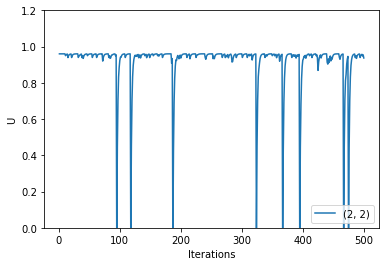

In [11]:
#Implementation of the DUE learning algorithm for the optimal policy of the 4 x 3 environment with no obstacles
DUEagent = PassiveDUEAgent(policy_1, sequential_decision_environment)

#Iterates through 200 trials and performs a trial of the DUEalgorithm at each trial. The utility values are then estimated
#each state utility value is printed.
for i in range(200):
    run_single_trial(DUEagent, sequential_decision_environment)
    DUEagent.estimate_U()  
DUE_utility_list = [str(k)+ ":" + str(v) for k, v in DUEagent.U.items()]
DUE_utility_list.sort()
print('\n'.join(DUE_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveDUEAgent(policy_1, sequential_decision_environment)

#Prints the graph of utility estimates for 500 iterations for the 4 x 3 environment state (2,2).
graph_utility_estimates_DUE(agent, sequential_decision_environment, 500, [(2,2)])

(0, 0):-0.900117251772116
(0, 1):0.804111328125
(0, 2):0.8786572265624999
(1, 0):-0.8598437748319631
(1, 1):-0.8209495087713004
(1, 2):0.9192984008789062
(2, 0):-0.8366657536333895
(2, 1):-0.7796874719858022
(2, 2):0.9578047314436117
(3, 0):-0.8996730995178223
(3, 1):-1.0
(3, 2):1.0


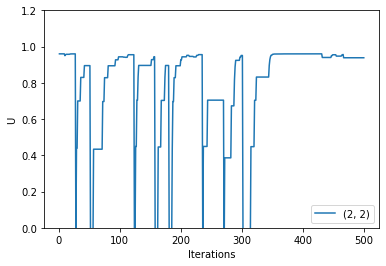

In [16]:
#Implementation of the DUE learning algorithm for the test policy 1 of the 4 x 3 environment with no obstacles
DUEagent = PassiveDUEAgent(policy43N1, sequential_decision_environment)

#Iterates through 200 trials and performs a trial of the DUEalgorithm at each trial. The utility values are then estimated
#each state utility value is printed.
for i in range(200):
    run_single_trial(DUEagent, sequential_decision_environment)
    DUEagent.estimate_U()  
DUE_utility_list = [str(k)+ ":" + str(v) for k, v in DUEagent.U.items()]
DUE_utility_list.sort()
print('\n'.join(DUE_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveDUEAgent(policy43N1, sequential_decision_environment)

#Prints the graph of utility estimates for 500 iterations for the 4 x 3 environment state (2,2).
graph_utility_estimates_DUE(agent, sequential_decision_environment, 500, [(2,2)])

(0, 0):0.7665149610399238
(0, 1):0.8282078563830135
(0, 2):0.8624283998021505
(1, 0):0.6980785767237345
(1, 1):0.8680228627319835
(1, 2):0.9145233481489619
(2, 0):0.15999999999999995
(2, 1):-0.7948670423030854
(2, 2):0.9553046523776856
(3, 1):-1.0
(3, 2):1.0


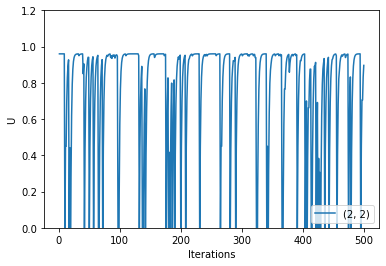

In [17]:
#Implementation of the DUE learning algorithm for the test policy 2 of the 4 x 3 environment with no obstacles
DUEagent = PassiveDUEAgent(policy43N2, sequential_decision_environment)

#Iterates through 200 trials and performs a trial of the DUEalgorithm at each trial. The utility values are then estimated
#each state utility value is printed.
for i in range(200):
    run_single_trial(DUEagent, sequential_decision_environment)
    DUEagent.estimate_U()  
DUE_utility_list = [str(k)+ ":" + str(v) for k, v in DUEagent.U.items()]
DUE_utility_list.sort()
print('\n'.join(DUE_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveDUEAgent(policy43N2, sequential_decision_environment)

#Prints the graph of utility estimates for 500 iterations for the 4 x 3 environment state (2,2).
graph_utility_estimates_DUE(agent, sequential_decision_environment, 500, [(2,2)])

## ADP Algorithm

(0, 0):0.31313350989492805
(0, 1):0.40301237512227867
(0, 2):0.5017925776696407
(1, 0):0.3961291552318083
(1, 1):0.5157614848689532
(1, 2):0.6460052928134212
(2, 0):0.0
(2, 1):0.5299923092208029
(2, 2):0.8056742873330615
(3, 0):0.0
(3, 1):-1.0
(3, 2):1.0


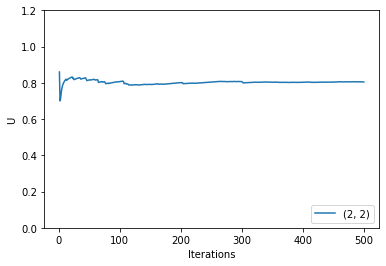

In [18]:
#Implementation of the ADP learning algorithm for the optimal policy of the 4 x 3 environment with no obstacles
ADPagent = PassiveADPAgent(policy_1, sequential_decision_environment)

#Iterates through 200 trials and performs a trial of the ADPalgorithm at each trial. Each state utility value is printed.
for i in range(200):
    run_single_trial(ADPagent, sequential_decision_environment)
    
ADP_utility_list = [str(k)+ ":" + str(v) for k, v in ADPagent.U.items()]
ADP_utility_list.sort()
print('\n'.join(ADP_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveADPAgent(policy_1, sequential_decision_environment)

#Prints the graph of utility estimates for 500 iterations for the 4 x 3 environment state (2,2).
graph_utility_estimates(agent, sequential_decision_environment, 500, [(2,2)])


(0, 0):-0.5462204531254442
(0, 1):0.12826595884515313
(0, 2):0.2559673739520005
(1, 0):-0.6587812018834295
(1, 1):-0.6514091728023432
(1, 2):0.3785748091156655
(2, 0):-0.6966429844930611
(2, 1):-0.7489229226200737
(2, 2):0.6970324112604173
(3, 0):-0.6657706376906155
(3, 1):-1.0
(3, 2):1.0


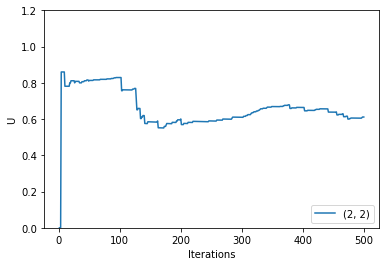

In [19]:
#Implementation of the ADP learning algorithm for the test policy 1 of the 4 x 3 environment with no obstacles
ADPagent = PassiveADPAgent(policy43N1, sequential_decision_environment)

#Iterates through 200 trials and performs a trial of the ADPalgorithm at each trial. Each state utility value is printed.
for i in range(200):
    run_single_trial(ADPagent, sequential_decision_environment)
    
ADP_utility_list = [str(k)+ ":" + str(v) for k, v in ADPagent.U.items()]
ADP_utility_list.sort()
print('\n'.join(ADP_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveADPAgent(policy43N1, sequential_decision_environment)

#Prints the graph of utility estimates for 500 iterations for the 4 x 3 environment state (2,2).
graph_utility_estimates(agent, sequential_decision_environment, 500, [(2,2)])


(0, 0):0.22191832208595
(0, 1):0.31267110388031294
(0, 2):0.4053474837588635
(1, 0):0.17754946495468668
(1, 1):0.3888672780145808
(1, 2):0.5265753831397033
(2, 0):-0.8860000000000001
(2, 1):-0.8703358403803437
(2, 2):0.6663063013912163
(3, 0):-0.9400000000000001
(3, 1):-1.0
(3, 2):1.0


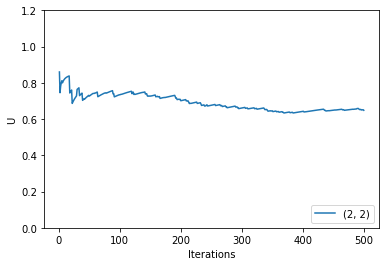

In [20]:
#Implementation of the ADP learning algorithm for the test policy 2 of the 4 x 3 environment with no obstacles
ADPagent = PassiveADPAgent(policy43N2, sequential_decision_environment)

#Iterates through 200 trials and performs a trial of the ADPalgorithm at each trial. Each state utility value is printed.
for i in range(200):
    run_single_trial(ADPagent, sequential_decision_environment)
    
ADP_utility_list = [str(k)+ ":" + str(v) for k, v in ADPagent.U.items()]
ADP_utility_list.sort()
print('\n'.join(ADP_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveADPAgent(policy43N2, sequential_decision_environment)

#Prints the graph of utility estimates for 500 iterations for the 4 x 3 environment state (2,2).
graph_utility_estimates(agent, sequential_decision_environment, 500, [(2,2)])


## TD Algorithm

(0, 0):0.31473809571445704
(0, 1):0.41558642299765436
(0, 2):0.5347746898558239
(1, 0):0.3284867039249662
(1, 1):0.5059056337152006
(1, 2):0.6656113846176102
(2, 0):0.10454151173975973
(2, 1):0.6331488350095842
(2, 2):0.8561465466315156
(3, 0):0.0
(3, 1):-1
(3, 2):1


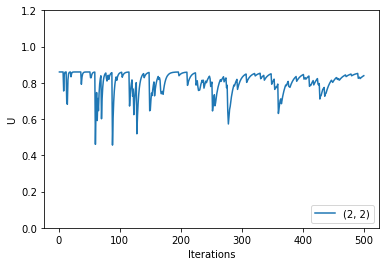

In [21]:
#Implementation of the TD learning algorithm for the optimal policy of the 4 x 3 environment with no obstacles
TDagent = PassiveTDAgent(policy_1, sequential_decision_environment, alpha = lambda n: 60./(59+n))

#Iterates through 200 trials and performs a trial of the ADPalgorithm at each trial. Each state utility value is printed.
for i in range(200):
    run_single_trial(TDagent,sequential_decision_environment)    
TD_utility_list = [str(k)+ ":" + str(v) for k, v in TDagent.U.items()]
TD_utility_list.sort()
print('\n'.join(TD_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveTDAgent(policy_1, sequential_decision_environment, alpha=lambda n: 60./(59+n))

#Prints the graph of utility estimates for 500 iterations for the 4 x 3 environment state (2,2).
graph_utility_estimates(agent, sequential_decision_environment, 500, [(2,2)])

(0, 0):-0.4512487135072706
(0, 1):0.4437040552313849
(0, 2):0.4071091690275963
(1, 0):-0.7423848400422477
(1, 1):-0.8332161600953091
(1, 2):0.609529219685405
(2, 0):-0.8035063046235402
(2, 1):-0.9324493160624142
(2, 2):-0.19023801368310378
(3, 0):-0.8873570929280008
(3, 1):-1
(3, 2):1


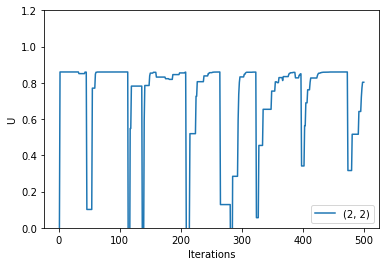

In [22]:
#Implementation of the TD learning algorithm for the test policy 1 of the 4 x 3 environment with no obstacles
TDagent = PassiveTDAgent(policy43N1, sequential_decision_environment, alpha = lambda n: 60./(59+n))

#Iterates through 200 trials and performs a trial of the ADPalgorithm at each trial. Each state utility value is printed.
for i in range(200):
    run_single_trial(TDagent,sequential_decision_environment)
TD_utility_list = [str(k)+ ":" + str(v) for k, v in TDagent.U.items()]
TD_utility_list.sort()
print('\n'.join(TD_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveTDAgent(policy43N1, sequential_decision_environment, alpha=lambda n: 60./(59+n))

#Prints the graph of utility estimates for 500 iterations for the 4 x 3 environment state (2,2).
graph_utility_estimates(agent, sequential_decision_environment, 500, [(2,2)])


(0, 0):0.19873245083607124
(0, 1):0.23787081196509047
(0, 2):0.3223132380365016
(1, 0):0.13457015483444298
(1, 1):0.14815827249861396
(1, 2):0.5050172916017975
(2, 0):-0.341516375181532
(2, 1):-0.9399804878210446
(2, 2):0.7879010944556584
(3, 0):-0.9400000000000001
(3, 1):-1
(3, 2):1


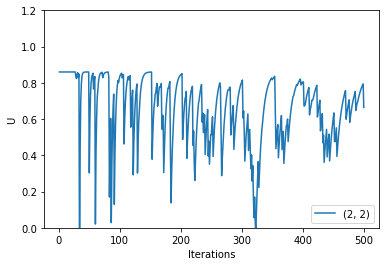

In [23]:
#Implementation of the TD learning algorithm for the test policy 2 of the 4 x 3 environment with no obstacles
TDagent = PassiveTDAgent(policy43N2, sequential_decision_environment, alpha = lambda n: 60./(59+n))
for i in range(200):
    run_single_trial(TDagent,sequential_decision_environment)
    
TD_utility_list = [str(k)+ ":" + str(v) for k, v in TDagent.U.items()]
TD_utility_list.sort()
print('\n'.join(TD_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveTDAgent(policy43N2, sequential_decision_environment, alpha=lambda n: 60./(59+n))

#Prints the graph of utility estimates for 500 iterations for the 4 x 3 environment state (2,2).
graph_utility_estimates(agent, sequential_decision_environment, 500, [(2,2)])


# (4 x 3 with obstacles)

### USES POLICIES policy_2, policy43W1, and policy43W2¶

## DUE Algorithm

(0, 0):0.6567166734530447
(0, 1):0.7263268213444379
(0, 2):0.7813271487733509
(1, 0):-0.1430996068318685
(1, 2):0.8754680902493327
(2, 0):-0.1027541319529216
(2, 1):0.7649841199528653
(2, 2):0.9517299715583791
(3, 0):0.73
(3, 1):-1.0
(3, 2):1.0


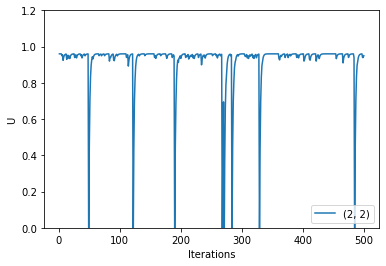

In [24]:
#Implementation of the DUE learning algorithm for the optimal policy of the 4 x 3 environment with obstacles
DUEagent = PassiveDUEAgent(policy_2, sequential_decision_environment_2)

#Iterates through 200 trials and performs a trial of the DUEalgorithm at each trial. The utility values are then estimated
#each state utility value is printed.
for i in range(200):
    run_single_trial(DUEagent, sequential_decision_environment_2)
    DUEagent.estimate_U()  
DUE_utility_list = [str(k)+ ":" + str(v) for k, v in DUEagent.U.items()]
DUE_utility_list.sort()
print('\n'.join(DUE_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveDUEAgent(policy_2, sequential_decision_environment_2)

#Prints the graph of utility estimates for 500 iterations for the 4 x 3 environment with obstacles state (2,2).
graph_utility_estimates_DUE(agent, sequential_decision_environment_2, 500, [(2,2)])

(0, 0):-0.6969116965073328
(0, 1):0.7036285993456841
(0, 2):0.7473919774095217
(1, 0):-0.6638766493115924
(1, 2):0.787404695302248
(2, 0):-0.6056536118363864
(2, 1):-0.5482407856141072
(2, 2):0.8934968450543687
(3, 0):-0.15007934570312503
(3, 1):-1.0
(3, 2):1.0


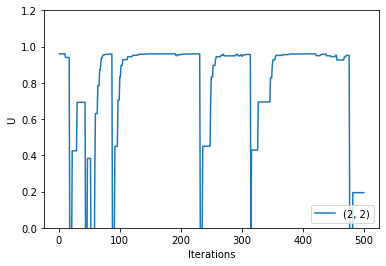

In [27]:
#Implementation of the DUE learning algorithm for the test policy 1 of the 4 x 3 environment with obstacles
DUEagent = PassiveDUEAgent(policy43W1, sequential_decision_environment_2)

#Iterates through 200 trials and performs a trial of the DUEalgorithm at each trial. The utility values are then estimated
#each state utility value is printed.
for i in range(200):
    run_single_trial(DUEagent, sequential_decision_environment_2)
    DUEagent.estimate_U()  
DUE_utility_list = [str(k)+ ":" + str(v) for k, v in DUEagent.U.items()]
DUE_utility_list.sort()
print('\n'.join(DUE_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveDUEAgent(policy43W1, sequential_decision_environment_2)

#Prints the graph of utility estimates for 500 iterations for the 4 x 3 environment with obstacles state (2,2).
graph_utility_estimates_DUE(agent, sequential_decision_environment_2, 500, [(2,2)])

(0, 0):0.13954693153919043
(0, 1):0.19965599890295968
(0, 2):0.24970847251119152
(1, 0):-0.6498733019828796
(1, 2):0.3248031775942066
(2, 0):-0.7425
(2, 1):-1.0674609518051148
(2, 2):0.38483164732111375
(3, 1):-1.0
(3, 2):1.0


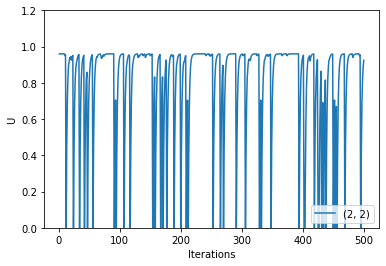

In [28]:
#Implementation of the DUE learning algorithm for the test policy 2 of the 4 x 3 environment with obstacles
DUEagent = PassiveDUEAgent(policy43W2, sequential_decision_environment_2)

#Iterates through 200 trials and performs a trial of the DUEalgorithm at each trial. The utility values are then estimated
#each state utility value is printed.
for i in range(200):
    run_single_trial(DUEagent, sequential_decision_environment_2)
    DUEagent.estimate_U()  
DUE_utility_list = [str(k)+ ":" + str(v) for k, v in DUEagent.U.items()]
DUE_utility_list.sort()
print('\n'.join(DUE_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveDUEAgent(policy43W2, sequential_decision_environment_2)

#Prints the graph of utility estimates for 500 iterations for the 4 x 3 environment with obstacles state (2,2).
graph_utility_estimates_DUE(agent, sequential_decision_environment_2, 500, [(2,2)])

## ADP Algorithm

(0, 0):0.3020333666067499
(0, 1):0.41652260979578415
(0, 2):0.528654304024923
(1, 0):0.19622954807797022
(1, 2):0.6542946135722244
(2, 0):0.2761165136701168
(2, 1):0.3754503928375662
(2, 2):0.8012442901516534
(3, 0):0.2085048623031051
(3, 1):-1.0
(3, 2):1.0


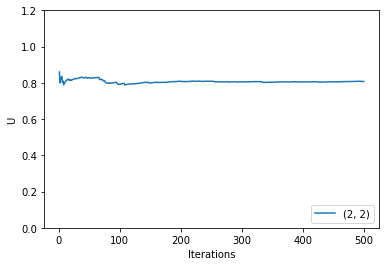

In [29]:
#Implementation of the ADP learning algorithm for the optimal policy of the 4 x 3 environment with obstacles
ADPagent = PassiveADPAgent(policy_2, sequential_decision_environment_2)

#Iterates through 200 trials and performs a trial of the ADPalgorithm at each trial. Each state utility value is printed.
for i in range(200):
    run_single_trial(ADPagent, sequential_decision_environment_2)
    
ADP_utility_list = [str(k)+ ":" + str(v) for k, v in ADPagent.U.items()]
ADP_utility_list.sort()
print('\n'.join(ADP_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveADPAgent(policy_2, sequential_decision_environment_2)

#Prints the graph of utility estimates for 500 iterations for the 4 x 3 environment with obstacles state (2,2).
graph_utility_estimates(agent, sequential_decision_environment_2, 500, [(2,2)])


(0, 0):-0.5970558648210035
(0, 1):0.27771003975069264
(0, 2):0.3852830621570261
(1, 0):-0.7054777620307543
(1, 2):0.5183783112545788
(2, 0):-0.7471263672672899
(2, 1):-0.8043187558403615
(2, 2):0.6504327089513374
(3, 0):-0.7152129228617583
(3, 1):-1.0
(3, 2):1.0


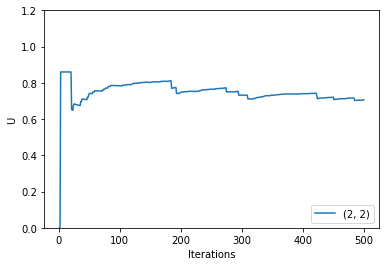

In [30]:
#Implementation of the ADP learning algorithm for the test policy 1 of the 4 x 3 environment with no obstacles
ADPagent = PassiveADPAgent(policy43W1, sequential_decision_environment_2)

#Iterates through 200 trials and performs a trial of the ADPalgorithm at each trial. Each state utility value is printed.
for i in range(200):
    run_single_trial(ADPagent, sequential_decision_environment_2)
    
ADP_utility_list = [str(k)+ ":" + str(v) for k, v in ADPagent.U.items()]
ADP_utility_list.sort()
print('\n'.join(ADP_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveADPAgent(policy43W1, sequential_decision_environment_2)

#Prints the graph of utility estimates for 500 iterations for the 4 x 3 environment with obstacles state (2,2).
graph_utility_estimates(agent, sequential_decision_environment_2, 500, [(2,2)])


(0, 0):0.2397042599531987
(0, 1):0.3332003921735586
(0, 2):0.4372768061387724
(1, 0):0.16497245388348977
(1, 2):0.5652897984151953
(2, 0):-0.8053706466744596
(2, 1):-0.8504118296382883
(2, 2):0.6966764654217079
(3, 0):0.0
(3, 1):-1.0
(3, 2):1.0


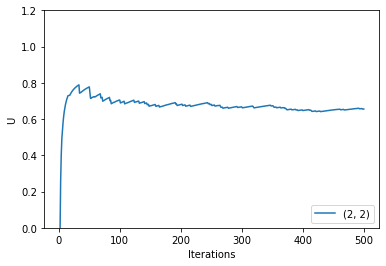

In [31]:
#Implementation of the ADP learning algorithm for the test policy 2 of the 4 x 3 environment with no obstacles
ADPagent = PassiveADPAgent(policy43W2, sequential_decision_environment_2)

#Iterates through 200 trials and performs a trial of the ADPalgorithm at each trial. Each state utility value is printed.
for i in range(200):
    run_single_trial(ADPagent, sequential_decision_environment_2)
    
ADP_utility_list = [str(k)+ ":" + str(v) for k, v in ADPagent.U.items()]
ADP_utility_list.sort()
print('\n'.join(ADP_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveADPAgent(policy43W2, sequential_decision_environment_2)

#Prints the graph of utility estimates for 500 iterations for the 4 x 3 environment with obstacles state (2,2).
graph_utility_estimates(agent, sequential_decision_environment_2, 500, [(2,2)])


## TD Algorithm

(0, 0):0.29122593514246686
(0, 1):0.3985074747991941
(0, 2):0.5131353432788262
(1, 0):0.08619547728769286
(1, 2):0.691854629921527
(2, 0):0.37995867291832286
(2, 1):0.6362552769217602
(2, 2):0.7953391270084943
(3, 0):-0.035643020791090135
(3, 1):-1
(3, 2):1


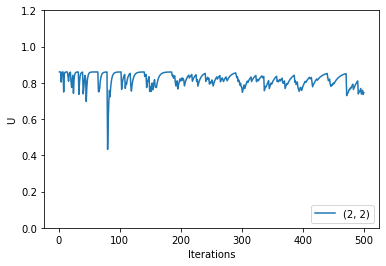

In [32]:
#Implementation of the TD learning algorithm for the optimal policy of the 4 x 3 environment with obstacles
TDagent = PassiveTDAgent(policy_2, sequential_decision_environment_2, alpha = lambda n: 60./(59+n))

#Iterates through 200 trials and performs a trial of the TDalgorithm at each trial. Each state utility value is printed.
for i in range(200):
    run_single_trial(TDagent,sequential_decision_environment_2)    
TD_utility_list = [str(k)+ ":" + str(v) for k, v in TDagent.U.items()]
TD_utility_list.sort()
print('\n'.join(TD_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveTDAgent(policy_2, sequential_decision_environment_2, alpha=lambda n: 60./(59+n))

#Prints the graph of utility estimates for 500 iterations for the 4 x 3 environment with obstacles state (2,2).
graph_utility_estimates(agent, sequential_decision_environment_2, 500, [(2,2)])

(0, 0):-0.7310979723568238
(0, 1):0.3012241610479196
(0, 2):0.4750730316892237
(1, 0):-0.7814042967905983
(1, 2):0.6864827975981292
(2, 0):-0.8224445431645631
(2, 1):-0.9170231964066958
(2, 2):0.8496010506982165
(3, 0):-0.7821513345254305
(3, 1):-1
(3, 2):1


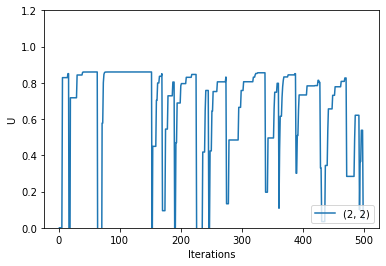

In [33]:
#Implementation of the TD learning algorithm for the test policy 1 of the 4 x 3 environment with obstacles
TDagent = PassiveTDAgent(policy43W1, sequential_decision_environment_2, alpha = lambda n: 60./(59+n))

#Iterates through 200 trials and performs a trial of the TDalgorithm at each trial. Each state utility value is printed.
for i in range(200):
    run_single_trial(TDagent,sequential_decision_environment_2)
TD_utility_list = [str(k)+ ":" + str(v) for k, v in TDagent.U.items()]
TD_utility_list.sort()
print('\n'.join(TD_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveTDAgent(policy43W1, sequential_decision_environment_2, alpha=lambda n: 60./(59+n))

#Prints the graph of utility estimates for 500 iterations for the 4 x 3 environment with obstacles state (2,2).
graph_utility_estimates(agent, sequential_decision_environment_2, 500, [(2,2)])

(0, 0):0.21061835674111143
(0, 1):0.3412817174671242
(0, 2):0.473619239049325
(1, 0):0.13317381637633757
(1, 2):0.6577206064481859
(2, 0):-0.3828169706708269
(2, 1):-0.9388117480491893
(2, 2):0.8341529001688819
(3, 0):0.0
(3, 1):-1
(3, 2):1


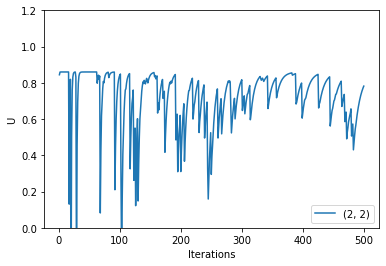

In [34]:
#Implementation of the TD learning algorithm for the test policy 1 of the 4 x 3 environment with obstacles
TDagent = PassiveTDAgent(policy43W2, sequential_decision_environment_2, alpha = lambda n: 60./(59+n))

#Iterates through 200 trials and performs a trial of the TDalgorithm at each trial. Each state utility value is printed.
for i in range(200):
    run_single_trial(TDagent,sequential_decision_environment_2)
TD_utility_list = [str(k)+ ":" + str(v) for k, v in TDagent.U.items()]
TD_utility_list.sort()
print('\n'.join(TD_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveTDAgent(policy43W2, sequential_decision_environment_2, alpha=lambda n: 60./(59+n))

#Prints the graph of utility estimates for 500 iterations for the 4 x 3 environment with obstacles state (2,2).
graph_utility_estimates(agent, sequential_decision_environment_2, 500, [(2,2)])

# (5 x 5 without obstacles)

### USES POLICIES policy_3, policy55N1, and policy55N2¶

## DUE Algorithm 

(0, 0):0.634566945383898
(0, 1):0.6772427647824788
(0, 2):0.7183266155431889
(0, 3):0.7375305404311081
(0, 4):0.7826792753825866
(1, 0):0.24328048706054692
(1, 1):0.5488656208646716
(1, 2):0.7041902528600528
(1, 3):0.8103020762834208
(1, 4):0.8610962820536792
(2, 0):0.68
(2, 1):0.8
(2, 2):0.8200000000000001
(2, 3):0.8768623214680702
(2, 4):0.9057982239055358
(3, 3):0.8576165471971036
(3, 4):0.9549938581883095
(4, 3):-1.0
(4, 4):1.0


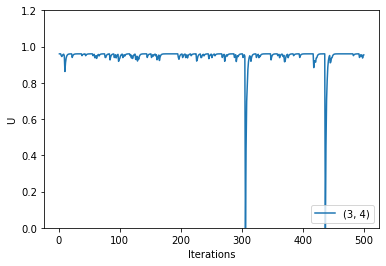

In [35]:
#Implementation of the DUE learning algorithm for the optimal policy of the 5 x 5 environment with no obstacles
DUEagent = PassiveDUEAgent(policy_3, sequential_decision_environment_3)

#Iterates through 200 trials and performs a trial of the DUEalgorithm at each trial. The utility values are then estimated
#each state utility value is printed.
for i in range(200):
    run_single_trial(DUEagent, sequential_decision_environment_3)
    DUEagent.estimate_U()  
DUE_utility_list = [str(k)+ ":" + str(v) for k, v in DUEagent.U.items()]
DUE_utility_list.sort()
print('\n'.join(DUE_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveDUEAgent(policy_3, sequential_decision_environment_3)

#Prints the graph of utility estimates for 500 iterations for the 5 x 5 environment with no obstacles state (3,4)
graph_utility_estimates_DUE(agent, sequential_decision_environment_3, 500, [(3,4)])

(0, 0):0.19005154062340218
(0, 1):-0.027166797965765044
(0, 2):0.014380265697836903
(0, 3):0.05565225534141072
(0, 4):0.8026897144317626
(1, 0):-0.25965684899433306
(1, 1):-0.11780531007796524
(1, 2):-0.07795372674862533
(1, 3):-0.7904386222362519
(1, 4):0.8304440323511759
(2, 0):-0.22006881783377052
(2, 1):-1.1855720769613982
(2, 2):-1.1600209192034527
(2, 3):-1.089440995454432
(2, 4):0.868634943291545
(3, 0):-0.18004100088809583
(3, 1):-0.1400335950321731
(3, 2):-0.10002625372726309
(3, 3):-0.06000984184745256
(3, 4):0.9503777257283218
(4, 0):-1.1255468750000002
(4, 1):-1.120342025756836
(4, 2):-1.0400029045715928
(4, 3):-1.0
(4, 4):1.0


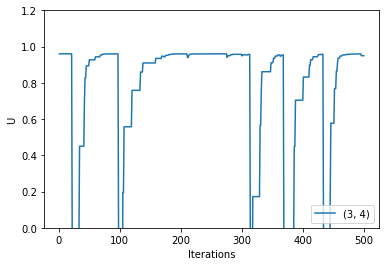

In [36]:
#Implementation of the DUE learning algorithm for the test policy 1 of the 5 x 5 environment with no obstacles
DUEagent = PassiveDUEAgent(policy55N1, sequential_decision_environment_3)

#Iterates through 200 trials and performs a trial of the DUEalgorithm at each trial. The utility values are then estimated
#each state utility value is printed.
for i in range(200):
    run_single_trial(DUEagent, sequential_decision_environment_3)
    DUEagent.estimate_U()  
DUE_utility_list = [str(k)+ ":" + str(v) for k, v in DUEagent.U.items()]
DUE_utility_list.sort()
print('\n'.join(DUE_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveDUEAgent(policy55N1, sequential_decision_environment_3)

#Prints the graph of utility estimates for 500 iterations for the 5 x 5 environment with no obstacles state (3,4)
graph_utility_estimates_DUE(agent, sequential_decision_environment_3, 500, [(3,4)])

(0, 0):0.6602262016405652
(0, 1):0.678582763671875
(0, 2):0.72364990234375
(0, 3):0.7638736979166667
(0, 4):0.7678125
(1, 0):0.6979546109546036
(1, 1):0.12008419036865231
(1, 2):0.76
(1, 3):0.84
(1, 4):0.809921875
(2, 0):0.7385905711248432
(2, 1):0.7564410383374552
(2, 2):0.6516671005263924
(2, 3):0.8670965116098523
(2, 4):0.8856250000000001
(3, 0):0.7706122867578025
(3, 1):0.8186019795336282
(3, 2):0.8592954614530002
(3, 3):0.899931544247637
(3, 4):0.951085805664752
(4, 0):0.675078125
(4, 1):0.7277212113095448
(4, 2):0.7805917961285473
(4, 3):-1.0
(4, 4):1.0


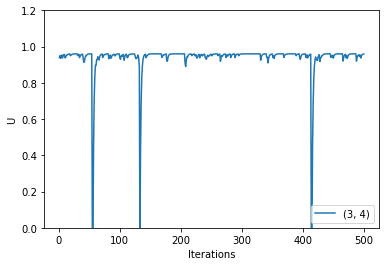

In [37]:
#Implementation of the DUE learning algorithm for the test policy 2 of the 5 x 5 environment with no obstacles
DUEagent = PassiveDUEAgent(policy55N2, sequential_decision_environment_3)

#Iterates through 200 trials and performs a trial of the DUEalgorithm at each trial. The utility values are then estimated
#each state utility value is printed.
for i in range(200):
    run_single_trial(DUEagent, sequential_decision_environment_3)
    DUEagent.estimate_U()  
DUE_utility_list = [str(k)+ ":" + str(v) for k, v in DUEagent.U.items()]
DUE_utility_list.sort()
print('\n'.join(DUE_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveDUEAgent(policy55N2, sequential_decision_environment_3)

#Prints the graph of utility estimates for 500 iterations for the 5 x 5 environment with no obstacles state (3,4)
graph_utility_estimates_DUE(agent, sequential_decision_environment_3, 500, [(3,4)])

## ADP Algorithm

(0, 0):0.10122899895141452
(0, 1):0.1605896790460067
(0, 2):0.22938812771519881
(0, 3):0.3053733074510963
(0, 4):0.39079807967017194
(1, 0):0.1760390261372356
(1, 1):0.23651819440515173
(1, 2):0.31697003134744023
(1, 3):0.405826405196102
(1, 4):0.510283014018776
(2, 0):0.2735324580870659
(2, 1):0.3483693978745176
(2, 2):0.4315215531939084
(2, 3):0.5239128368821374
(2, 4):0.6502279185705349
(3, 0):0.0
(3, 1):0.0
(3, 2):0.0
(3, 3):0.5792044806158615
(3, 4):0.8052236557011613
(4, 0):0.0
(4, 1):0.0
(4, 2):0.0
(4, 3):-1.0
(4, 4):1.0


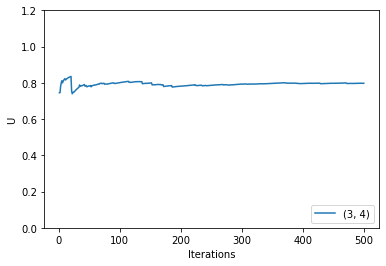

In [38]:
#Implementation of the ADP learning algorithm for the optimal policy of the 5 x 5 environment with no obstacles
ADPagent = PassiveADPAgent(policy_3, sequential_decision_environment_3)

#Iterates through 200 trials and performs a trial of the ADPalgorithm at each trial. Each state utility value is printed.
for i in range(200):
    run_single_trial(ADPagent, sequential_decision_environment_3)
    
ADP_utility_list = [str(k)+ ":" + str(v) for k, v in ADPagent.U.items()]
ADP_utility_list.sort()
print('\n'.join(ADP_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveADPAgent(policy_3, sequential_decision_environment_3)

#Prints the graph of utility estimates for 500 iterations for the 5 x 5 environment with no obstacles state (3,4)
graph_utility_estimates(agent, sequential_decision_environment_3, 500, [(3,4)])

(0, 0):-0.5251561496936302
(0, 1):-0.2438823446512305
(0, 2):-0.18532716439127966
(0, 3):-0.08272742513240494
(0, 4):0.035419686695658946
(1, 0):-0.5757123501799597
(1, 1):-0.48391469308183555
(1, 2):-0.5039107673119341
(1, 3):-0.5254707279477034
(1, 4):0.12820687242202417
(2, 0):-0.6164501749773458
(2, 1):-0.593183678880992
(2, 2):-0.6220469459486675
(2, 3):-0.6516731642108644
(2, 4):0.3126083930653126
(3, 0):-0.6449308506824097
(3, 1):-0.6720076351231177
(3, 2):-0.7055201050261561
(3, 3):-0.7341996261384462
(3, 4):0.6625495091026724
(4, 0):-0.7295437511589821
(4, 1):-0.793099473027156
(4, 2):-0.8617908654149338
(4, 3):-1.0
(4, 4):1.0


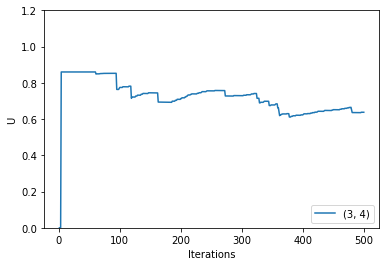

In [39]:
#Implementation of the ADP learning algorithm for the test policy 1 of the 5 x 5 environment with no obstacles
ADPagent = PassiveADPAgent(policy55N1, sequential_decision_environment_3)

#Iterates through 200 trials and performs a trial of the ADPalgorithm at each trial. Each state utility value is printed.
for i in range(200):
    run_single_trial(ADPagent, sequential_decision_environment_3)
    
ADP_utility_list = [str(k)+ ":" + str(v) for k, v in ADPagent.U.items()]
ADP_utility_list.sort()
print('\n'.join(ADP_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveADPAgent(policy55N1, sequential_decision_environment_3)

#Prints the graph of utility estimates for 500 iterations for the 5 x 5 environment with no obstacles state (3,4)
graph_utility_estimates(agent, sequential_decision_environment_3, 500, [(3,4)])

(0, 0):-0.004043539510480525
(0, 1):0.11511814912054111
(0, 2):0.2009918503955816
(0, 3):0.28131166635104776
(0, 4):0.3647655488460275
(1, 0):0.03399016519128916
(1, 1):0.09871202406438465
(1, 2):0.17109242447654122
(1, 3):0.3434837968639266
(1, 4):0.46783962602056534
(2, 0):0.0908002051106288
(2, 1):0.17584370332948515
(2, 2):0.2685059168680094
(2, 3):0.4260931076265865
(2, 4):0.6171344310312004
(3, 0):0.14892826240968537
(3, 1):0.2513981208872753
(3, 2):0.36819538857267753
(3, 3):0.5234413089737333
(3, 4):0.8059804945337369
(4, 0):0.040704707653905055
(4, 1):0.09194707471456401
(4, 2):0.12132846419179524
(4, 3):-1.0
(4, 4):1.0


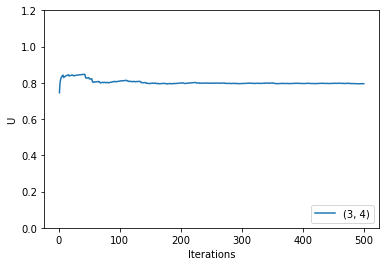

In [40]:
#Implementation of the ADP learning algorithm for the test policy 2 of the 5 x 5 environment with no obstacles
ADPagent = PassiveADPAgent(policy55N2, sequential_decision_environment_3)

#Iterates through 200 trials and performs a trial of the ADPalgorithm at each trial. Each state utility value is printed.
for i in range(200):
    run_single_trial(ADPagent, sequential_decision_environment_3)
    
ADP_utility_list = [str(k)+ ":" + str(v) for k, v in ADPagent.U.items()]
ADP_utility_list.sort()
print('\n'.join(ADP_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveADPAgent(policy55N2, sequential_decision_environment_3)

#Prints the graph of utility estimates for 500 iterations for the 5 x 5 environment with no obstacles state (3,4)
graph_utility_estimates(agent, sequential_decision_environment_3, 500, [(3,4)])


## TD Algorithm

(0, 0):0.11606369872731916
(0, 1):0.1977482593059994
(0, 2):0.2692472081978942
(0, 3):0.34299110497917346
(0, 4):0.44382028696307074
(1, 0):0.13634742599649513
(1, 1):0.2263779231837939
(1, 2):0.3216977548803972
(1, 3):0.41639593045263806
(1, 4):0.5416765853095515
(2, 0):0.2194810724648334
(2, 1):0.29290828182887735
(2, 2):0.39334200055555213
(2, 3):0.555925809223821
(2, 4):0.6312896532502292
(3, 0):0.0
(3, 1):-0.07600000000000001
(3, 2):0.09595414499185684
(3, 3):0.3171851158370328
(3, 4):0.6495779981648234
(4, 0):0.0
(4, 1):0.0
(4, 2):0.0
(4, 3):-1
(4, 4):1


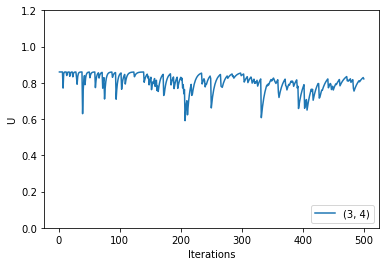

In [41]:
#Implementation of the TD learning algorithm for the optimal policy of the 5 x 5 environment with no obstacles
TDagent = PassiveTDAgent(policy_3, sequential_decision_environment_3, alpha = lambda n: 60./(59+n))

#Iterates through 200 trials and performs a trial of the TDalgorithm at each trial. Each state utility value is printed.
for i in range(200):
    run_single_trial(TDagent,sequential_decision_environment_3)    
TD_utility_list = [str(k)+ ":" + str(v) for k, v in TDagent.U.items()]
TD_utility_list.sort()
print('\n'.join(TD_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveTDAgent(policy_3, sequential_decision_environment_3, alpha=lambda n: 60./(59+n))

#Prints the graph of utility estimates for 500 iterations for the 5 x 5 environment with no obstacles state (3,4)
graph_utility_estimates(agent, sequential_decision_environment_3, 500, [(3,4)])

(0, 0):-0.4864539966364347
(0, 1):-0.18602389695709212
(0, 2):-0.09901222236434509
(0, 3):0.17695836122507405
(0, 4):0.45290930998849444
(1, 0):-0.577714232603996
(1, 1):-0.49143585149721003
(1, 2):-0.5331584581820792
(1, 3):-0.6062881648422782
(1, 4):0.581944650468925
(2, 0):-0.6130354846546627
(2, 1):-0.5415850052679625
(2, 2):-0.5680845533636213
(2, 3):-0.67479196979024
(2, 4):0.7064008347006044
(3, 0):-0.6156464152086242
(3, 1):-0.6303909506635178
(3, 2):-0.6340756255380617
(3, 3):-0.8471075916783314
(3, 4):0.8522431559312577
(4, 0):-0.8225027901769948
(4, 1):-0.8399606634499421
(4, 2):-0.7588488630797999
(4, 3):-1
(4, 4):1


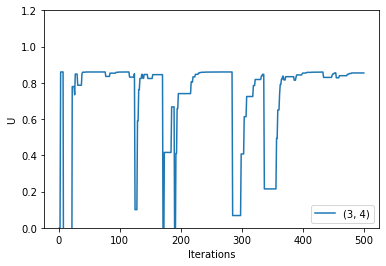

In [42]:
#Implementation of the TD learning algorithm for the test policy 1 of the 5 x 5 environment with no obstacles
TDagent = PassiveTDAgent(policy55N1, sequential_decision_environment_3, alpha = lambda n: 60./(59+n))

#Iterates through 200 trials and performs a trial of the TDalgorithm at each trial. Each state utility value is printed.
for i in range(200):
    run_single_trial(TDagent,sequential_decision_environment_3)
TD_utility_list = [str(k)+ ":" + str(v) for k, v in TDagent.U.items()]
TD_utility_list.sort()
print('\n'.join(TD_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveTDAgent(policy55N1, sequential_decision_environment_3, alpha=lambda n: 60./(59+n))

#Prints the graph of utility estimates for 500 iterations for the 5 x 5 environment with no obstacles state (3,4)
graph_utility_estimates(agent, sequential_decision_environment_3, 500, [(3,4)])

(0, 0):0.020318516415884637
(0, 1):0.12122339468683407
(0, 2):0.20203570516195946
(0, 3):0.17741366708025913
(0, 4):0.25436888677694275
(1, 0):0.05636183327388468
(1, 1):0.11544498783145313
(1, 2):0.19330147644347537
(1, 3):0.3943310369208308
(1, 4):0.45271606943025
(2, 0):0.07177714924005266
(2, 1):0.16392094628773127
(2, 2):0.2847609275353623
(2, 3):0.4531154305176847
(2, 4):0.2177812306014928
(3, 0):0.1632870537192323
(3, 1):0.30607994337588795
(3, 2):0.454064115087886
(3, 3):0.6260761670855836
(3, 4):0.8521242729579805
(4, 0):-0.040083664039589
(4, 1):0.12191890180718398
(4, 2):0.2683293865209323
(4, 3):-1
(4, 4):1


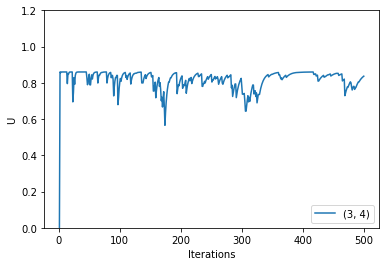

In [43]:
#Implementation of the TD learning algorithm for the test policy 2 of the 5 x 5 environment with no obstacles
TDagent = PassiveTDAgent(policy55N2, sequential_decision_environment_3, alpha = lambda n: 60./(59+n))

#Iterates through 200 trials and performs a trial of the TDalgorithm at each trial. Each state utility value is printed.
for i in range(200):
    run_single_trial(TDagent,sequential_decision_environment_3)
    
TD_utility_list = [str(k)+ ":" + str(v) for k, v in TDagent.U.items()]
TD_utility_list.sort()
print('\n'.join(TD_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveTDAgent(policy55N2, sequential_decision_environment_3, alpha=lambda n: 60./(59+n))

#Prints the graph of utility estimates for 500 iterations for the 5 x 5 environment with no obstacles state (3,4).
graph_utility_estimates(agent, sequential_decision_environment_3, 500, [(3,4)])


# (5 x 5 with obstacles)

### USES POLICIES policy_4, policy55W1, and policy55W2

## DUE Algorithm

(0, 0):-0.3155357649640709
(0, 1):0.6889217352916873
(0, 2):0.7290903842500644
(0, 3):0.7772442310104519
(0, 4):0.8235336178548087
(1, 0):-0.27827667236328124
(1, 4):0.8676067277225921
(2, 0):-0.2318171183268229
(2, 1):-0.1901394653320312
(2, 2):-0.15036254882812505
(2, 3):-0.10126012184516486
(2, 4):0.9099097617571867
(3, 0):0.72
(3, 1):0.8200000000000001
(3, 2):0.865
(3, 3):-0.06255071878433227
(3, 4):0.9599949633228108
(4, 2):0.84
(4, 3):-1.0
(4, 4):1.0


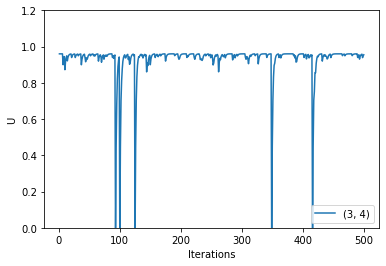

In [44]:
#Implementation of the DUE learning algorithm for the optimal policy of the 5 x 5 environment with obstacles
DUEagent = PassiveDUEAgent(policy_4, sequential_decision_environment_4)

#Iterates through 200 trials and performs a trial of the DUEalgorithm at each trial. The utility values are then estimated
#each state utility value is printed.
for i in range(200):
    run_single_trial(DUEagent, sequential_decision_environment_4)
    DUEagent.estimate_U()  
DUE_utility_list = [str(k)+ ":" + str(v) for k, v in DUEagent.U.items()]
DUE_utility_list.sort()
print('\n'.join(DUE_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveDUEAgent(policy_4, sequential_decision_environment_4)

#Prints the graph of utility estimates for 500 iterations for the 5 x 5 environment with obstacles state (3,4).
graph_utility_estimates_DUE(agent, sequential_decision_environment_4, 500, [(3,4)])

(0, 0):-1.3595961340722735
(0, 1):-0.569002523124218
(0, 2):-0.5250668904185295
(0, 3):-0.46062588661909104
(0, 4):-0.3974103972315788
(1, 0):-1.296900287080987
(1, 4):-0.3494732327759265
(2, 0):-1.233694166772585
(2, 1):-1.135313806249372
(2, 2):-1.1075482249775583
(2, 3):-1.0648504641118053
(2, 4):-0.2007468686252833
(3, 0):-1.1911773503153729
(3, 1):-1.1305466450762705
(3, 2):-1.0807807660466837
(3, 3):-1.0400000130376108
(3, 4):0.6571864227492794
(4, 0):-1.1604302978515626
(4, 1):-1.1206115794181823
(4, 2):-1.0703764345496893
(4, 3):-1.0
(4, 4):1.0


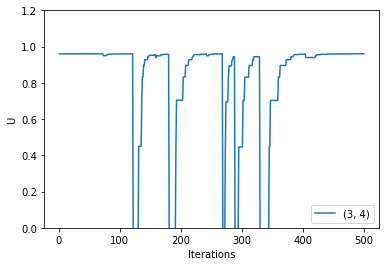

In [45]:
#Implementation of the DUE learning algorithm for the test policy 1 of the 5 x 5 environment with obstacles
DUEagent = PassiveDUEAgent(policy55W1, sequential_decision_environment_4)

#Iterates through 200 trials and performs a trial of the DUEalgorithm at each trial. The utility values are then estimated
#each state utility value is printed.
for i in range(200):
    run_single_trial(DUEagent, sequential_decision_environment_4)
    DUEagent.estimate_U()  
DUE_utility_list = [str(k)+ ":" + str(v) for k, v in DUEagent.U.items()]
DUE_utility_list.sort()
print('\n'.join(DUE_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveDUEAgent(policy55W1, sequential_decision_environment_4)

#Prints the graph of utility estimates for 500 iterations for the 5 x 5 environment with obstacles state (3,4).
graph_utility_estimates_DUE(agent, sequential_decision_environment_4, 500, [(3,4)])

(0, 0):0.6144059222037408
(0, 1):0.6544886207580567
(0, 2):0.6961829626560211
(0, 3):0.7403701759974162
(0, 4):0.7866973292827606
(1, 0):0.6542080640311849
(1, 4):0.8315475463867188
(2, 0):0.7145529135586517
(2, 1):0.7297369659976539
(2, 2):0.8077308273315429
(2, 3):0.8523081970214843
(2, 4):0.8836483812332154
(3, 0):0.7297375337370402
(3, 1):0.831004852760685
(3, 2):0.8640590261251564
(3, 3):0.9119848516941285
(3, 4):0.9534079306817126
(4, 0):0.61697021484375
(4, 1):0.6391151079535484
(4, 2):0.6900655591662508
(4, 3):-1.0
(4, 4):1.0


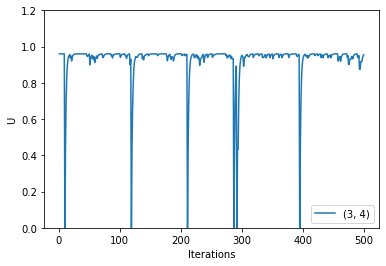

In [46]:
#Implementation of the DUE learning algorithm for the test policy 2 of the 5 x 5 environment with obstacles
DUEagent = PassiveDUEAgent(policy55W2, sequential_decision_environment_4)

#Iterates through 200 trials and performs a trial of the DUEalgorithm at each trial. The utility values are then estimated
#each state utility value is printed.
for i in range(200):
    run_single_trial(DUEagent, sequential_decision_environment_4)
    DUEagent.estimate_U()  
DUE_utility_list = [str(k)+ ":" + str(v) for k, v in DUEagent.U.items()]
DUE_utility_list.sort()
print('\n'.join(DUE_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveDUEAgent(policy55W2, sequential_decision_environment_4)

#Prints the graph of utility estimates for 500 iterations for the 5 x 5 environment with obstacles state (3,4).
graph_utility_estimates_DUE(agent, sequential_decision_environment_4, 500, [(3,4)])

## ADP Algorithm

(0, 0):0.0759498988651752
(0, 1):0.13594037133457237
(0, 2):0.20933788989009364
(0, 3):0.29396815237547863
(0, 4):0.3907542199232784
(1, 0):0.13616964355857025
(1, 4):0.5138786813715203
(2, 0):0.2207268633806301
(2, 1):0.31243904373281317
(2, 2):0.4122330983781291
(2, 3):0.5175916430496034
(2, 4):0.6354930278589452
(3, 0):0.13622884942670394
(3, 1):0.25241176690696465
(3, 2):0.4217541618181186
(3, 3):0.5130601797979095
(3, 4):0.801080691195219
(4, 0):0.08260596427508379
(4, 1):0.03434536784757542
(4, 2):0.0
(4, 3):-1.0
(4, 4):1.0


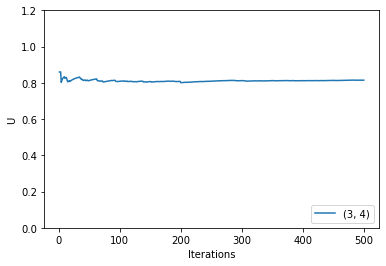

In [47]:
#Implementation of the ADP learning algorithm for the optimal policy of the 5 x 5 environment with obstacles
ADPagent = PassiveADPAgent(policy_4, sequential_decision_environment_4)

#Iterates through 200 trials and performs a trial of the ADPalgorithm at each trial. Each state utility value is printed.
for i in range(200):
    run_single_trial(ADPagent, sequential_decision_environment_4)
    
ADP_utility_list = [str(k)+ ":" + str(v) for k, v in ADPagent.U.items()]
ADP_utility_list.sort()
print('\n'.join(ADP_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveADPAgent(policy_4, sequential_decision_environment_4)

#Prints the graph of utility estimates for 500 iterations for the 5 x 5 environment with obstacles state (3,4).
graph_utility_estimates(agent, sequential_decision_environment_4, 500, [(3,4)])

(0, 0):-0.5313319145622288
(0, 1):0.061170882688776
(0, 2):0.13351141330386565
(0, 3):0.19976446462845726
(0, 4):0.29095672240803666
(1, 0):-0.6042349363239762
(1, 4):0.39200636350726836
(2, 0):-0.6342439555047099
(2, 1):-0.6077815158432458
(2, 2):-0.6246816455371811
(2, 3):-0.645610968244472
(2, 4):0.4903600949232036
(3, 0):-0.6718300736262874
(3, 1):-0.7064968578664302
(3, 2):-0.7457933300324797
(3, 3):-0.7917244257088969
(3, 4):0.6609268824328854
(4, 0):-0.7652438889867936
(4, 1):-0.821697372775412
(4, 2):-0.9012378005805076
(4, 3):-1.0
(4, 4):1.0


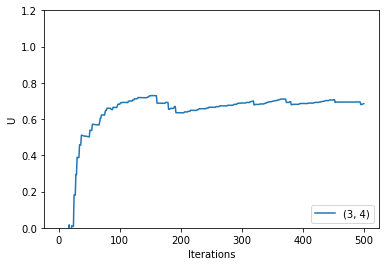

In [48]:
#Implementation of the ADP learning algorithm for the test policy 1 of the 5 x 5 environment with obstacles
ADPagent = PassiveADPAgent(policy55W1, sequential_decision_environment_4)

#Iterates through 200 trials and performs a trial of the ADPalgorithm at each trial. Each state utility value is printed.
for i in range(200):
    run_single_trial(ADPagent, sequential_decision_environment_4)
    
ADP_utility_list = [str(k)+ ":" + str(v) for k, v in ADPagent.U.items()]
ADP_utility_list.sort()
print('\n'.join(ADP_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveADPAgent(policy55W1, sequential_decision_environment_4)

#Prints the graph of utility estimates for 500 iterations for the 5 x 5 environment with obstacles state (3,4).
graph_utility_estimates(agent, sequential_decision_environment_4, 500, [(3,4)])

(0, 0):-0.0010793522888823334
(0, 1):0.13684122142756797
(0, 2):0.2089171261564454
(0, 3):0.28503176692618004
(0, 4):0.37473830783320033
(1, 0):0.03551894226525746
(1, 4):0.5008786921641663
(2, 0):0.09573273541944402
(2, 1):0.18052399430427063
(2, 2):0.28494806408930895
(2, 3):0.4163895356933448
(2, 4):0.6176592633706326
(3, 0):0.15329298213583653
(3, 1):0.25017118755409357
(3, 2):0.3688153098703563
(3, 3):0.5119961581136323
(3, 4):0.8050657723603528
(4, 0):0.017531664342823168
(4, 1):0.0641250070011454
(4, 2):0.10696736905420712
(4, 3):-1.0
(4, 4):1.0


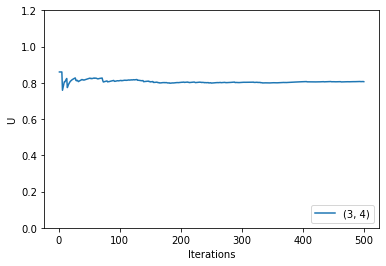

In [49]:
#Implementation of the ADP learning algorithm for the test policy 2 of the 5 x 5 environment with obstacles
ADPagent = PassiveADPAgent(policy55W2, sequential_decision_environment_4)

#Iterates through 200 trials and performs a trial of the ADPalgorithm at each trial. Each state utility value is printed.
for i in range(200):
    run_single_trial(ADPagent, sequential_decision_environment_4)
    
ADP_utility_list = [str(k)+ ":" + str(v) for k, v in ADPagent.U.items()]
ADP_utility_list.sort()
print('\n'.join(ADP_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveADPAgent(policy55W2, sequential_decision_environment_4)

#Prints the graph of utility estimates for 500 iterations for the 5 x 5 environment with obstacles state (3,4).
graph_utility_estimates(agent, sequential_decision_environment_4, 500, [(3,4)])


## TD Algorithm

(0, 0):0.11745092964776778
(0, 1):0.18378869792114833
(0, 2):0.2677262282643806
(0, 3):0.35206414086506643
(0, 4):0.4275571427706259
(1, 0):0.18633697954896314
(1, 4):0.5355235243822347
(2, 0):0.18702387297741402
(2, 1):0.17565886104267053
(2, 2):-0.06718072477251852
(2, 3):0.4741768686558321
(2, 4):0.6793677308861016
(3, 0):0.35534988917371896
(3, 1):0.4023291255067756
(3, 2):0.2817284917481596
(3, 3):0.3830209285060041
(3, 4):0.8453932521625193
(4, 0):0.0
(4, 1):0.0
(4, 2):-0.07351818213097251
(4, 3):-1
(4, 4):1


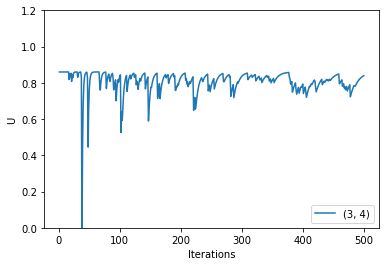

In [50]:
#Implementation of the TD learning algorithm for the optimal policy of the 5 x 5 environment with obstacles
TDagent = PassiveTDAgent(policy_4, sequential_decision_environment_4, alpha = lambda n: 60./(59+n))

#Iterates through 200 trials and performs a trial of the TDalgorithm at each trial. Each state utility value is printed.
for i in range(200):
    run_single_trial(TDagent,sequential_decision_environment_4)    
TD_utility_list = [str(k)+ ":" + str(v) for k, v in TDagent.U.items()]
TD_utility_list.sort()
print('\n'.join(TD_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveTDAgent(policy_4, sequential_decision_environment_4, alpha=lambda n: 60./(59+n))

#Prints the graph of utility estimates for 500 iterations for the 5 x 5 environment with obstacles state (3,4).
graph_utility_estimates(agent, sequential_decision_environment_4, 500, [(3,4)])

(0, 0):-0.5801090640989035
(0, 1):0.13157709941743478
(0, 2):0.2779694055085686
(0, 3):0.3980083640485742
(0, 4):0.509794912341623
(1, 0):-0.5863263977855078
(1, 4):0.617658944486008
(2, 0):-0.612848785572459
(2, 1):-0.3199826428277003
(2, 2):0.009739500272422534
(2, 3):-0.4261130452142454
(2, 4):0.6892849976727259
(3, 0):-0.6704202740882639
(3, 1):-0.6334850006703368
(3, 2):-0.8360861123080071
(3, 3):-0.8852310553214053
(3, 4):0.8507157885288587
(4, 0):-0.7475423967109587
(4, 1):-0.7233192243553853
(4, 2):-0.8438619479672909
(4, 3):-1
(4, 4):1


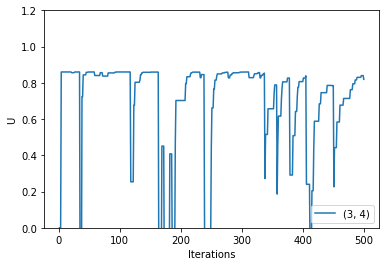

In [51]:
#Implementation of the TD learning algorithm for the test policy 1 of the 5 x 5 environment with obstacles
TDagent = PassiveTDAgent(policy55W1, sequential_decision_environment_4, alpha = lambda n: 60./(59+n))

#Iterates through 200 trials and performs a trial of the TDalgorithm at each trial. Each state utility value is printed.
for i in range(200):
    run_single_trial(TDagent,sequential_decision_environment_4)
TD_utility_list = [str(k)+ ":" + str(v) for k, v in TDagent.U.items()]
TD_utility_list.sort()
print('\n'.join(TD_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveTDAgent(policy55W1, sequential_decision_environment_4, alpha=lambda n: 60./(59+n))

#Prints the graph of utility estimates for 500 iterations for the 5 x 5 environment with obstacles state (3,4).
graph_utility_estimates(agent, sequential_decision_environment_4, 500, [(3,4)])

(0, 0):0.027877251952607613
(0, 1):0.18830204210941645
(0, 2):0.2771572196868879
(0, 3):0.38471706509545894
(0, 4):0.4910575355323344
(1, 0):0.052684427743268425
(1, 4):0.590341654671782
(2, 0):0.11137183196661615
(2, 1):0.16578523854657945
(2, 2):0.29933249621089786
(2, 3):0.3191316917695572
(2, 4):0.684796983211904
(3, 0):0.18229693878324216
(3, 1):0.27269132045175504
(3, 2):0.36533958507656805
(3, 3):0.5319668515408856
(3, 4):0.8230544875303419
(4, 0):0.11641620178325005
(4, 1):0.23113889048592678
(4, 2):-0.0633673014488303
(4, 3):-1
(4, 4):1


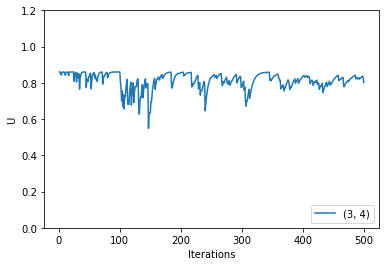

In [52]:
#Implementation of the TD learning algorithm for the test policy 2 of the 5 x 5 environment with obstacles
TDagent = PassiveTDAgent(policy55W2, sequential_decision_environment_4, alpha = lambda n: 60./(59+n))

#Iterates through 200 trials and performs a trial of the TDalgorithm at each trial. Each state utility value is printed.
for i in range(200):
    run_single_trial(TDagent,sequential_decision_environment_4)
    
TD_utility_list = [str(k)+ ":" + str(v) for k, v in TDagent.U.items()]
TD_utility_list.sort()
print('\n'.join(TD_utility_list))

#New agent is created for the graph_utility estimates (MAINLY DONE SINCE ERROR THROWN WHEN USING SAME OBJECT AS PREVIOUS)
agent = PassiveTDAgent(policy55W2, sequential_decision_environment_4, alpha=lambda n: 60./(59+n))

#Prints the graph of utility estimates for 500 iterations for the 5 x 5 environment with obstacles state (3,4).
graph_utility_estimates(agent, sequential_decision_environment_4, 500, [(3,4)])
